In [1]:
import modin.pandas as pd  # type: ignore[import]
import pandas as native_pd
import numpy as np
from snowflake.snowpark import Session
import snowflake.snowpark.modin.plugin
from snowflake.snowpark.functions import col, lit
from typing import  Tuple
session = Session.builder.getOrCreate()


DATABASE_NAME = "astronomer_perf"
CUSTOMERS_TABLE = "customers"
ORDERS_TABLE = "orders"
PAYMENTS_TABLE = "payments"
SUBSCRIPTION_PERIODS_TABLE = "subscription_periods"
CUSTOMER_CONVERSIONS_TABLE = "customer_conversions"
SESSIONS_TABLE = "sessions"
schema = f"astronomer_sf100"


def _orders_table_fqn_source() -> str:
    return ".".join([DATABASE_NAME, schema, ORDERS_TABLE])  # type: ignore[attr-defined]

def _customers_table_fqn_source() -> str:
    return ".".join([DATABASE_NAME, schema, CUSTOMERS_TABLE])  # type: ignore[attr-defined]

def _payments_table_fqn_source() -> str:
    return ".".join([DATABASE_NAME, schema, PAYMENTS_TABLE])  # type: ignore[attr-defined]


def _orders_table_fqn(scale: int) -> str:
    return ".".join([DATABASE_NAME, schema, f"jvk_{SESSIONS_TABLE}_{ORDERS_TABLE}_{scale}"])  # type: ignore[attr-defined]

def _payments_table_fqn(scale: int) -> str:
    return ".".join([DATABASE_NAME, schema, f"jvk_{SESSIONS_TABLE}_{PAYMENTS_TABLE}_{scale}"])  # type: ignore[attr-defined]

def _customers_table_fqn(scale) -> str:
    return ".".join([DATABASE_NAME, schema, f"jvk_{SESSIONS_TABLE}_{CUSTOMERS_TABLE}_{scale}"])  # type: ignore[attr-defined]


def replicate_and_ingest_pandas_dataframe(session: Session, table_name: str, frame: native_pd.DataFrame, scale_factor: int) -> None:

    if scale_factor == 0:
        scale_factor = 1

    # find a non-existing identifier
    dummy_identifier = "dummy"
    i = 0
    while dummy_identifier in frame.columns:
        dummy_identifier = f"dummy{i}"
        i += 1

    # ingest into snowflake with replication
    dummy_expr = lit(1).as_(dummy_identifier)
    df_rep = session.sql(
        f"SELECT row_number() over (order by null)"
        f" as n from table (generator(rowcount => {scale_factor}))"
    ).select(dummy_expr)

    # join with original dataset amended by 1
    df = session.create_dataframe(frame).cache_result()
    df = df.select([dummy_expr] + [col(name) for name in df.columns])
    df = df_rep.join(df, on=dummy_identifier).select(
        [col(name) for name in df.columns[1:]]
    )

    # write to table (overwrite each time)
    #print(df.to_pandas().shape, table_name)
    df.write.save_as_table(table_name, mode="overwrite", table_type="temp")

def get_scale_customers(scale: int):
    customer_df = pd.read_snowflake(
        _customers_table_fqn_source()
    ).to_pandas()
    scaled_table_name = _customers_table_fqn(scale)
    replicate_and_ingest_pandas_dataframe(session, scaled_table_name, customer_df, scale)
    return pd.read_snowflake(scaled_table_name)


def get_scale_orders(scale:int):
    orders_df = pd.read_snowflake(
        _orders_table_fqn_source()
    ).to_pandas()
    scaled_table_name = _orders_table_fqn(scale)
    replicate_and_ingest_pandas_dataframe(session, scaled_table_name, orders_df, scale)
    return pd.read_snowflake(scaled_table_name)  

def get_scale_payments(scale: int):
    payments_df = pd.read_snowflake(
        _payments_table_fqn_source()
    ).to_pandas()
    scaled_table_name = _payments_table_fqn(scale)
    replicate_and_ingest_pandas_dataframe(session, scaled_table_name, payments_df, scale)
    return pd.read_snowflake(scaled_table_name)

In [2]:
scale_map_customers = {}
scale_map_orders = {}
scale_map_payments = {}

for scale in range(0, 1000, 100):
    scale_map_customers[scale] = get_scale_customers(scale)
    scale_map_orders[scale] = get_scale_orders(scale)
    scale_map_payments[scale] = get_scale_payments(scale)    

The current operation leads to materialization and can be slow if the data is large!


In [3]:
def run_pure_snowpark_pandas_jaffle_shop(
    customers_df: pd.DataFrame,
    orders_df: pd.DataFrame,
    payments_df: pd.DataFrame,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    customers_df.columns = customers_df.columns.str.lower()
    orders_df.columns = orders_df.columns.str.lower()
    payments_df.columns = payments_df.columns.str.lower()

    orders_df["order_date"] = pd.to_datetime(orders_df["order_date"])

    customer_orders_df = orders_df.groupby("customer_id").agg(
        {"order_date": ["min", "max"], "order_id": "count"}
    )
    customer_orders_df.columns = [
        "first_order",
        "most_recent_order",
        "number_of_orders",
    ]
    customer_payments_df = (
        payments_df.merge(orders_df, how="left", on="order_id")
        .groupby("customer_id")["amount"]
        .sum()
        / 100
    )
    customers = customers_df.merge(
        customer_orders_df, how="left", on="customer_id"
    ).merge(customer_payments_df, how="left", on="customer_id")

    customers.rename({"amount": "customer_lifetime_value"}, axis=1, inplace=True)
    customers = customers.reset_index(drop=True)

    orders = (
        payments_df.drop("payment_id", axis=1)
        .pivot_table(
            columns="payment_method",
            index="order_id",
            values="amount",
            aggfunc="sum",
        )
        .reset_index()
    )

    # bug here in customer code, need to explicitly specify numeric_only=True.
    orders = orders.merge(
        payments_df.groupby("order_id").sum(numeric_only=True), on="order_id"
    )

    orders = orders.merge(orders_df, on="order_id")

    # customer bug here, forgot to add `columns` as keyword. In original code, this was a no-op.
    orders.rename(columns={"amount": "total_amount"}, inplace=True)

    return customers, orders

In [4]:
def run_strategy_A_jaffle_shop(
    customers_df: pd.DataFrame,
    orders_df: pd.DataFrame,
    payments_df: pd.DataFrame,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # Convert to pandas immediately
    customers_df = customers_df.to_pandas()
    orders_df = orders_df.to_pandas()
    payments_df = payments_df.to_pandas()

    customers_df.columns = customers_df.columns.str.lower()
    orders_df.columns = orders_df.columns.str.lower()
    payments_df.columns = payments_df.columns.str.lower()

    orders_df["order_date"] = native_pd.to_datetime(orders_df["order_date"])

    customer_orders_df = orders_df.groupby("customer_id").agg(
        {"order_date": ["min", "max"], "order_id": "count"}
    )
    customer_orders_df.columns = [
        "first_order",
        "most_recent_order",
        "number_of_orders",
    ]
    customer_payments_df = (
        payments_df.merge(orders_df, how="left", on="order_id")
        .groupby("customer_id")["amount"]
        .sum()
        / 100
    )
    customers = customers_df.merge(
        customer_orders_df, how="left", on="customer_id"
    ).merge(customer_payments_df, how="left", on="customer_id")

    customers.rename({"amount": "customer_lifetime_value"}, axis=1, inplace=True)
    customers = customers.reset_index(drop=True)

    orders = (
        payments_df.drop("payment_id", axis=1)
        .pivot_table(
            columns="payment_method",
            index="order_id",
            values="amount",
            aggfunc="sum",
        )
        .reset_index()
    )

    # bug here in customer code, need to explicitly specify numeric_only=True.
    orders = orders.merge(
        payments_df.groupby("order_id").sum(numeric_only=True), on="order_id"
    )

    orders = orders.merge(orders_df, on="order_id")

    # customer bug here, forgot to add `columns` as keyword. In original code, this was a no-op.
    orders.rename(columns={"amount": "total_amount"}, inplace=True)

    return customers, orders

In [5]:
import time

record_data = []
for scale in range(0, 1000, 100):
    if scale == 0:
        real_scale = 1
    else:
        real_scale = scale
    start_time = time.time()
    tuple(map(repr, run_pure_snowpark_pandas_jaffle_shop(customers_df=scale_map_customers[scale],
                                         orders_df=scale_map_orders[scale],
                                         payments_df=scale_map_payments[scale])))
    stop_time = time.time()
    duration_snowpandas = stop_time - start_time

    start_time = time.time()
    tuple(map(repr, run_strategy_A_jaffle_shop(customers_df=scale_map_customers[scale],
                                         orders_df=scale_map_orders[scale],
                                         payments_df=scale_map_payments[scale])))
    stop_time = time.time()
    duration_native = stop_time - start_time
    record = [scale, len(scale_map_customers[scale]), len(scale_map_orders[scale]), len(scale_map_payments[scale]), duration_snowpandas, duration_native]
    record_data.append(record)
    record_df = native_pd.DataFrame(record_data, columns=['scale', 'num_customers_rows', 'num_orders_rows', 'num_payments_rows', 'snowpandas_duration', 'hybrid_duration'])
    print(record)
    

record_df


Snowflake automatic format detection is used when a format is not provided.In this case Snowflake's auto format may yield different result values compared to pandas.See https://docs.snowflake.com/en/sql-reference/date-time-input-output#supported-formats-for-auto-detection for details.


[0, 100, 99, 113, 3.343179941177368, 0.5100741386413574]
[100, 10000, 9900, 11300, 3.1326191425323486, 1.5686209201812744]
[200, 20000, 19800, 22600, 3.0297882556915283, 1.69753098487854]
[300, 30000, 29700, 33900, 3.114262104034424, 2.1240038871765137]
[400, 40000, 39600, 45200, 3.387410879135132, 2.5987489223480225]
[500, 50000, 49500, 56500, 3.438232183456421, 3.2547898292541504]
[600, 60000, 59400, 67800, 3.9807469844818115, 4.348941802978516]
[700, 70000, 69300, 79100, 4.213614225387573, 5.5694358348846436]
[800, 80000, 79200, 90400, 4.2492570877075195, 6.773384094238281]
[900, 90000, 89100, 101700, 4.673128128051758, 7.933723211288452]


,scale,num_customers_rows,num_orders_rows,num_payments_rows,snowpandas_duration,hybrid_duration
0,0,100,99,113,3.343180,0.510074
1,100,10000,9900,11300,3.132619,1.568621
2,200,20000,19800,22600,3.029788,1.697531
3,300,30000,29700,33900,3.114262,2.124004
4,400,40000,39600,45200,3.387411,2.598749
5,500,50000,49500,56500,3.438232,3.254790
6,600,60000,59400,67800,3.980747,4.348942
7,700,70000,69300,79100,4.213614,5.569436
8,800,80000,79200,90400,4.249257,6.773384
9,900,90000,89100,101700,4.673128,7.933723


In [6]:
record_df

,scale,num_customers_rows,num_orders_rows,num_payments_rows,snowpandas_duration,hybrid_duration
0,0,100,99,113,3.343180,0.510074
1,100,10000,9900,11300,3.132619,1.568621
2,200,20000,19800,22600,3.029788,1.697531
3,300,30000,29700,33900,3.114262,2.124004
4,400,40000,39600,45200,3.387411,2.598749
5,500,50000,49500,56500,3.438232,3.254790
6,600,60000,59400,67800,3.980747,4.348942
7,700,70000,69300,79100,4.213614,5.569436
8,800,80000,79200,90400,4.249257,6.773384
9,900,90000,89100,101700,4.673128,7.933723


In [7]:
record_df.to_csv("results-whee.csv")

,scale,num_customers_rows,num_orders_rows,num_payments_rows,snowpandas_duration,hybrid_duration,total rows
0,0,100,99,113,3.343180,0.510074,312
1,100,10000,9900,11300,3.132619,1.568621,31200
2,200,20000,19800,22600,3.029788,1.697531,62400
3,300,30000,29700,33900,3.114262,2.124004,93600
4,400,40000,39600,45200,3.387411,2.598749,124800
5,500,50000,49500,56500,3.438232,3.254790,156000
6,600,60000,59400,67800,3.980747,4.348942,187200
7,700,70000,69300,79100,4.213614,5.569436,218400
8,800,80000,79200,90400,4.249257,6.773384,249600
9,900,90000,89100,101700,4.673128,7.933723,280800


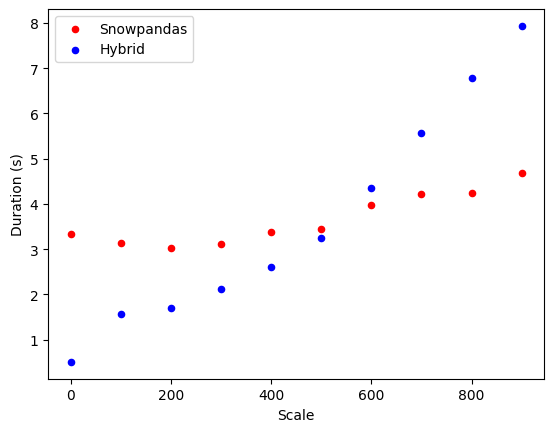

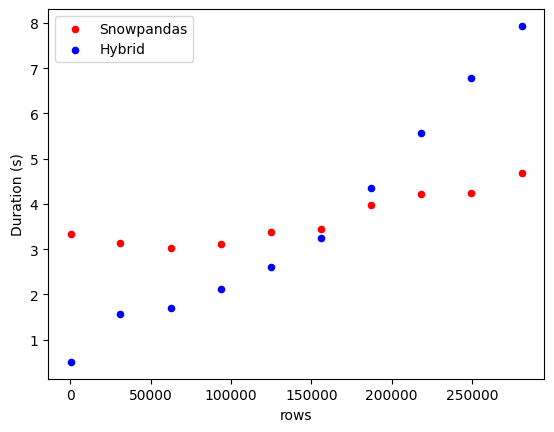

In [8]:
ax1 = record_df.plot(kind='scatter', x="scale", y="snowpandas_duration", color='r', label="Snowpandas")
record_df.plot(kind='scatter', x="scale", y="hybrid_duration", ax=ax1, color='b', label="Hybrid")
ax1.set_ylabel('Duration (s)')
ax1.set_xlabel('Scale')

byrows = record_df
byrows['total rows'] = byrows['num_customers_rows'] + byrows['num_orders_rows'] + byrows['num_payments_rows']

ax2 = byrows.plot(kind='scatter', x='total rows', y="snowpandas_duration", color='r', label="Snowpandas")
byrows.plot(kind='scatter', x='total rows', y="hybrid_duration", ax=ax2, color='b', label="Hybrid")
ax2.set_ylabel('Duration (s)')
ax2.set_xlabel('rows')

record_df